In [4]:
import pandas as pd
import os
WORKING_LOCALLY = bool(os.getenv('WORKING_LOCALLY'))

PROCESSED_DATASET_FILE_PATH = 'data/processed_dataset.csv' if WORKING_LOCALLY \
    else '/content/drive/My Drive/Projects/IRBoardGameComplexity/processed_dataset.csv'

if not WORKING_LOCALLY:
    from google.colab import drive
    drive.mount('/content/drive')

df_features = pd.read_csv(PROCESSED_DATASET_FILE_PATH)
df_features.head()

Mounted at /content/drive


,averageweight,playingtime,rulebook_len,abstracts,cgs,childrensgames,familygames,partygames,strategygames,thematic,wargames
0,2.1579,60,668,0,0,0,1,0,0,0,0
1,3.1452,90,14647,0,0,0,0,0,1,0,0
2,1.8100,90,4146,0,0,0,0,0,0,1,0
3,1.4858,30,2899,0,0,0,1,0,0,0,0
4,2.7813,120,686,0,0,0,0,0,1,0,0


In [5]:
from collections import namedtuple
from typing import Generator, Tuple, List
from sklearn.model_selection import KFold

FeaturesWithPrediction = namedtuple('FeaturesWithPrediction', ['y', 'x'])
SplitDataset = namedtuple('SplitDataset', ['train', 'test'])

def get_actual_value(dataset: pd.DataFrame) -> pd.DataFrame:
    return dataset.iloc[:, 0]

def get_features(dataset: pd.DataFrame) -> pd.DataFrame:
    return dataset.iloc[:, 1:]

def get_train_test_from_cv(kfold: KFold, dataset: pd.DataFrame) \
    -> Generator[SplitDataset, None, None]:
    '''generate K groups of train and test set from CV ((train_y, train_x), (test_y, test_x))'''
    for train_indices, test_indices in kfold.split(dataset):
        train = dataset.iloc[train_indices]
        test = dataset.iloc[test_indices]
        yield SplitDataset(\
                           FeaturesWithPrediction(get_actual_value(train), get_features(train)),
                           FeaturesWithPrediction(get_actual_value(test), get_features(test))
                           )

class Model:
    def __init__(self, instance):
        self.instance = instance
        self.name = instance.__class__.__name__

In [14]:
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from typing import List

MIN_COMPLEXITY, MAX_COMPLEXITY = 0, 5
MAX_PLOT_IN_ROW = 3
PLOT_INCHES = 6

def decorate_subplot(index: int, ax, i_model: int, title: str, y_test, predictions) -> None:
    row = i_model // MAX_PLOT_IN_ROW
    col = i_model % MAX_PLOT_IN_ROW
    subplot = ax[row][col]
    subplot.set_title(title)
    subplot.axis([MIN_COMPLEXITY, MAX_COMPLEXITY, MIN_COMPLEXITY, MAX_COMPLEXITY])
    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Actual')
    subplot.grid(True)
    subplot.plot(predictions, y_test, 'ro', [MIN_COMPLEXITY, MAX_COMPLEXITY], [MIN_COMPLEXITY, MAX_COMPLEXITY])

def create_containing_plot(plot_id: int, models: List[Model]): 
    num_models = len(models)
    containing_plot_rows = math.ceil(num_models / MAX_PLOT_IN_ROW)
    containing_plot_height = containing_plot_rows * PLOT_INCHES
    fig, ax = plt.subplots(nrows=containing_plot_rows, ncols=MAX_PLOT_IN_ROW, squeeze=False,
                           figsize=(MAX_PLOT_IN_ROW * PLOT_INCHES, containing_plot_rows * PLOT_INCHES), 
                           num=plot_id)
    for i in range(containing_plot_rows * MAX_PLOT_IN_ROW - num_models):
        fig.delaxes(ax[-1][MAX_PLOT_IN_ROW - i - 1])
    
    return fig, ax

def create_header(text: str):
    display(widgets.HTML(
        value=f"<h1>{text}</h1>"
    ))

HTML(value='<h1>Linear Models</h1>')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

HTML(value='<h1>Support Vector Machines</h1>')

HTML(value='<h1>Kernel Ridge</h1>')

,Model,Score,MAE,MAPE,MSE
0,LinearRegression,0.667196,0.366359,0.171940,0.201635
0,LassoCV,0.464565,0.452255,0.238367,0.309148
0,ElasticNetCV,0.464525,0.452279,0.238378,0.309171
0,RidgeCV,0.668840,0.364806,0.171049,0.200639
0,BayesianRidge,0.669952,0.363500,0.170347,0.199965
0,HuberRegressor,0.721008,0.323863,0.146731,0.169032
0,TweedieRegressor,0.530311,0.422400,0.219062,0.271188
0,QuantileRegressor,0.520482,0.420800,0.198193,0.290525
0,SVR,0.313103,0.490395,0.230385,0.416168
0,KernelRidge,-0.472590,0.749960,0.351817,0.850241


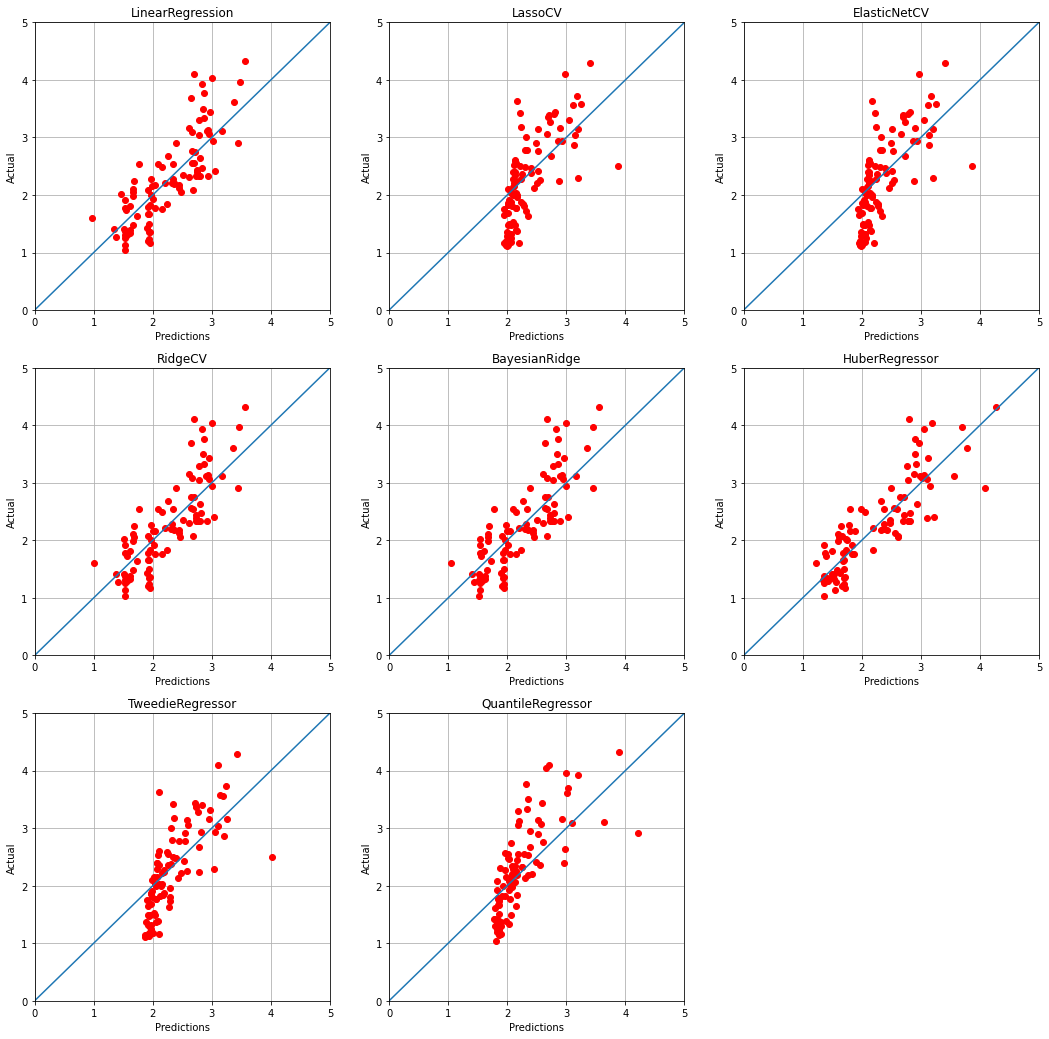

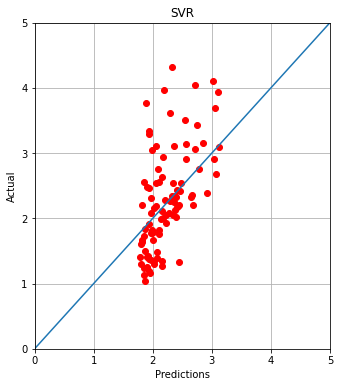

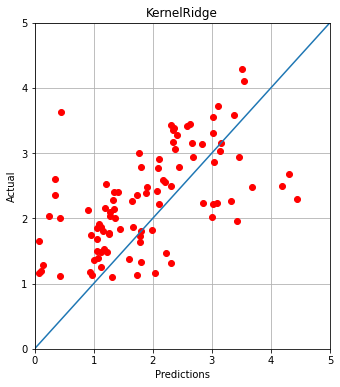

In [16]:
import numpy as np
from sklearn import linear_model, svm, kernel_ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

models = {
    'Linear Models': [
        Model(linear_model.LinearRegression()),
        Model(linear_model.LassoCV()),
        Model(linear_model.ElasticNetCV()),
        Model(linear_model.RidgeCV()),
        Model(linear_model.BayesianRidge()),
        Model(linear_model.HuberRegressor()),
        Model(linear_model.TweedieRegressor()),
        Model(linear_model.QuantileRegressor())
    ],
    'Support Vector Machines': [Model(svm.SVR())],
    'Kernel Ridge': [Model(kernel_ridge.KernelRidge())]
}

results = pd.DataFrame(columns=['Model', 'Score', 'MAE', 'MAPE', 'MSE'])
kfold = KFold(4)
for i_category, item in enumerate(models.items()):
    create_header(item[0])
    fig, ax = create_containing_plot(i_category, item[1])
    for i_m, model in enumerate(item[1]):
        # with cross_validate or cross_val_score the time and memory needed would have been higher
        best_cv_estimator, best_cv_score, best_cv_predictions, best_cv_test_y = None, None, None, None
        for split_dataset in get_train_test_from_cv(kfold, df_features):
            estimator = model.instance.fit(split_dataset.train.x, split_dataset.train.y)
            predictions = model.instance.predict(split_dataset.test.x)
            score = r2_score(split_dataset.test.y, predictions)

            if best_cv_score is None or best_cv_score < score:
                best_cv_estimator = estimator
                best_cv_score = score
                best_cv_predictions = predictions
                best_cv_test_y = split_dataset.test.y

        results = pd.concat([results, pd.DataFrame([
            { 
                'Model': model.name, 'Score': best_cv_score, 
                'MAE': mean_absolute_error(best_cv_test_y, best_cv_predictions),
                'MAPE': mean_absolute_percentage_error(best_cv_test_y, best_cv_predictions),
                'MSE': mean_squared_error(best_cv_test_y, best_cv_predictions)
            }
            ])])
        decorate_subplot(i_category, ax, i_m, model.name, best_cv_test_y, best_cv_predictions)

results